In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import timm
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.functional as F
from torch import nn

from src.notebooks_utils import get_data, get_synth_examples, show_grid
from src.adv_resnet import resnet50, EightBN
from src.imagenet_labels import IMAGENET_LABELS
from src.utils import normalize_model

In [4]:
torch.manual_seed(0)
torch.backends.cudnn.benchmark = False

In [5]:
plt.rcParams["savefig.bbox"] = 'tight'
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
output_dir = Path("outputs") / "interpretability"

In [6]:
# Set up model
CHECKPOINTS_DIR = "../checkpoints"

xcit_checkpoint_file = "xcit-imagenet-4-norm.pth.tar"
xcit_model_name = "xcit_small_12_p16_224"
xcit = timm.create_model(xcit_model_name, checkpoint_path=os.path.join(CHECKPOINTS_DIR, xcit_checkpoint_file))
xcit = normalize_model(xcit, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
xcit = xcit.to(device)

resnet_checkpoint_file = "advres50_gelu.pth"
resnet = resnet50(norm_layer=EightBN)
resnet.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, resnet_checkpoint_file))["model"])
resnet = normalize_model(resnet, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
resnet = resnet.to(device)

benign_xcit = timm.create_model(xcit_model_name, pretrained=True)
benign_xcit = normalize_model(benign_xcit, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
benign_xcit = benign_xcit.to(device)

In [7]:
n_examples = 16
ex_to_show = 6

In [8]:
xcit_x, xcit_x_adv, xcit_y = get_synth_examples(xcit, device, n_examples)

In [9]:
benign_xcit_x, benign_xcit_x_adv, benign_xcit_y = get_synth_examples(benign_xcit, device, n_examples)

In [10]:
resnet_x, resnet_x_adv, resnet_y = get_synth_examples(resnet, device, n_examples)

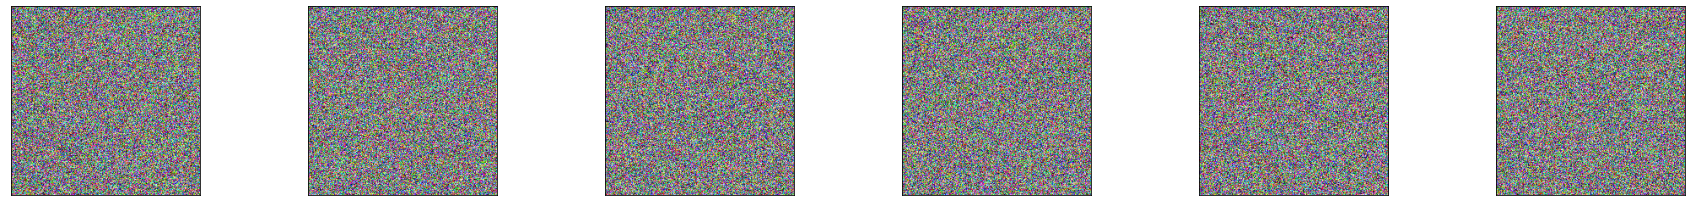

In [11]:
show_grid(xcit_x[ex_to_show:], filename=output_dir / "seeds.pdf")

In [12]:
labels = [IMAGENET_LABELS[l] for l in xcit_y]
print(", ".join(labels))

small white, feather boa, pot, Border Collie, European green lizard, ski, modem, Pomeranian, centipede, hermit crab, sombrero, monastery, tank suit, Komondor, partridge, Cocker Spaniels


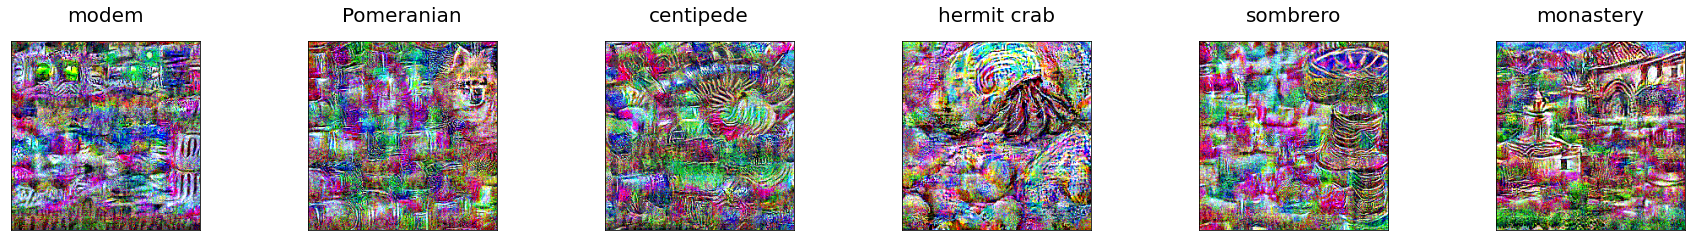

In [13]:
show_grid(xcit_x_adv[ex_to_show:], labels=labels[ex_to_show:], filename=output_dir / "xcit_robust.pdf")

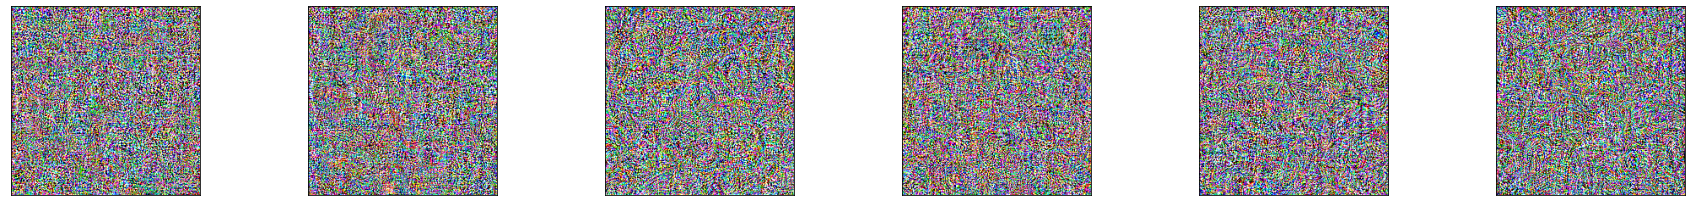

In [14]:
show_grid(benign_xcit_x_adv[ex_to_show:], filename=output_dir / "xcit_benign.pdf")

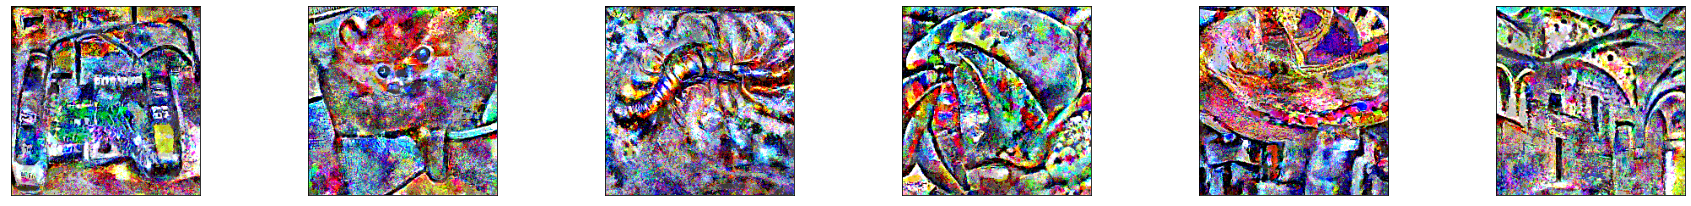

In [15]:
show_grid(resnet_x_adv[ex_to_show:], filename=output_dir / "resnet.pdf")